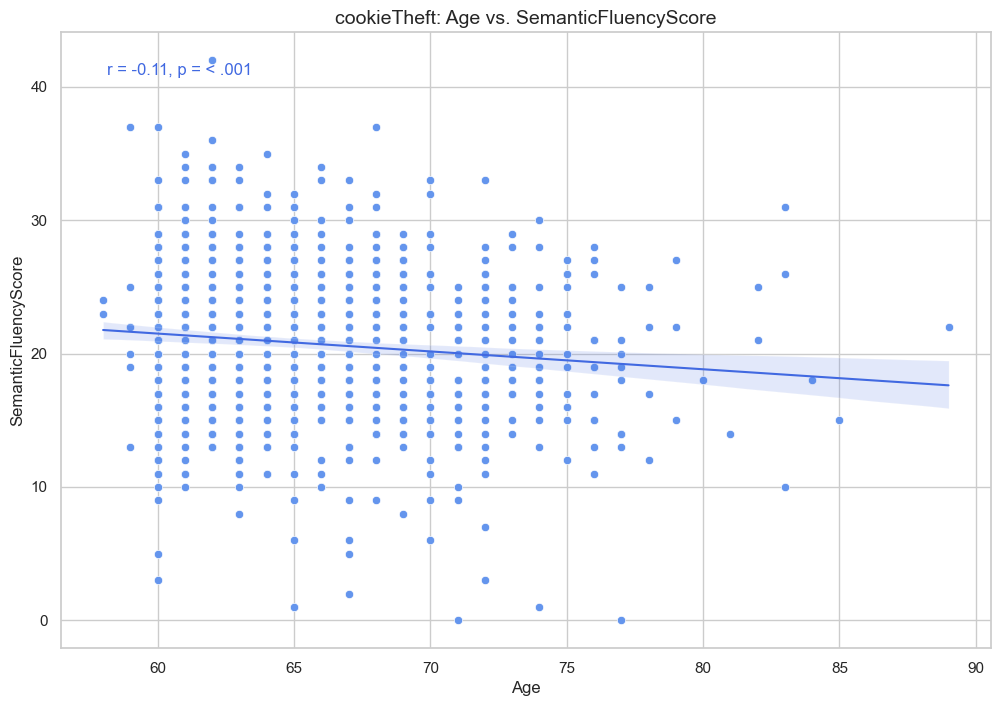

In [20]:
# setup
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from scipy.stats import pearsonr

# add project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")

from config.constants import GIT_DIRECTORY

# define variables
task_name = "cookieTheft"
feature_name = "Age"
target = "SemanticFluencyScore"

# load data
scores_path = os.path.join(GIT_DIRECTORY, "data", "language_scores_all_subjects.csv")
features_path = os.path.join(GIT_DIRECTORY, f"results/features/filtered/{task_name}_filtered.csv")
demographics_path = os.path.join(GIT_DIRECTORY, "data", "demographics_data.csv")
features = pd.read_csv(features_path)
scores = pd.read_csv(scores_path)
demographics = pd.read_csv(demographics_path)
df = pd.merge(features, demographics, on="Subject_ID", how="left")
df = pd.merge(df, scores[["Subject_ID", target]], on="Subject_ID", how="left")
df = df[[feature_name, target]].dropna()

# saving
save_dir = os.path.join(GIT_DIRECTORY, "results", "plots", "feature_vs_target")
os.makedirs(save_dir, exist_ok=True)

# calculate correlation
r, p = pearsonr(df[feature_name], df[target])
corr_text = f"r = {r:.2f}, p = {'< .001' if p < 0.001 else f'= {p:.3f}'}"

# plot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.scatterplot(data=df, x=feature_name, y=target, color="cornflowerblue")
sns.regplot(data=df, x=feature_name, y=target, scatter=False, color="royalblue", ci=95, line_kws={"linewidth": 1.5})

# title and labels
plt.text(
    0.05, 0.95, corr_text,
    transform=plt.gca().transAxes,
    ha="left", va="top",
    fontsize=12, color="royalblue",
)
plt.title(f"{task_name}: {feature_name} vs. {target}", fontsize=14)
plt.xlabel(feature_name)
plt.ylabel(target)
plt.savefig(os.path.join(GIT_DIRECTORY, "results", "plots", "feature_vs_target", f"{task_name}_{feature_name}_{target}_correlation.png"), dpi=300)
plt.show()